### import

In [35]:
BASEDIR="../"
BASEDIR

'../'

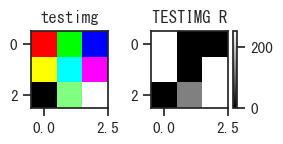

array([[[255,   0,   0],
        [  0, 255,   0],
        [  0,   0, 255]],

       [[255, 255,   0],
        [  0, 255, 255],
        [255,   0, 255]],

       [[  0,   0,   0],
        [128, 255, 128],
        [255, 255, 255]]], dtype=uint8)

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", font='MS Gothic', palette='tab10')
import numpy as np
import itertools
import pprint
import colorsys
import cv2
import os
from tqdm import tqdm;from IPython.display import clear_output
from scipy.interpolate import RegularGridInterpolator

def FindImageFiles(directory):
    image_files = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            # 拡張子がjpgまたはpngの場合にのみ追加
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(filepath)
    return image_files

def FilenameWOExt(path):
    return os.path.splitext(os.path.basename(path))[0]

def Padding(img, targetX, targetY):
    # img.shapeがtargetになる様に右/下 方向に0を追加
    x, y, _ = img.shape
    # iとjがxとy以上であるかチェック
    if targetX < x or targetY < y:
        # そうでなければ元のimgを返す
        return img
    else:
        # パディングする量を計算
        pad_width = ((0,targetX-x),(0,targetY-y),(0,0))
        img2 = np.pad(img,
                      pad_width=pad_width,
                      mode="constant", # パディング方式は定数（constant）で値は0にする
                      constant_values=0)
        return img2

def Scale(image, scale, interpolation=cv2.INTER_NEAREST):
    if scale == 1:
        return image
    else:
        return cv2.resize(image, None, None, scale, scale, interpolation=interpolation)
    
class GridPlot:
    def __init__(self, gridsize: tuple, figsize: tuple = (6, 4)):
        self.fig = plt.figure(figsize=figsize)
        self.x, self.y = gridsize

    def AddImg(self, image, i: int, title="", interpolation="none"):
        ax = self.fig.add_subplot(self.x, self.y, i)

        if len(image.shape) != 3:
            raise TypeError("image shape is wrong!")
        elif image.shape[2] == 1:
            if image.dtype != np.dtype("uint8") and image.dtype != np.dtype("float32"):
                raise TypeError("image dtype is wrong!")
            elif image.dtype == np.dtype("uint8"):
                im = ax.imshow(image, cmap='gray', vmin=0, vmax=255,
                               interpolation=interpolation)
            elif image.dtype == np.dtype("float32"):
                im = ax.imshow(image, cmap='gray', vmin=0, vmax=1,
                               interpolation=interpolation)
            plt.colorbar(im, ax=ax)  # 凡例バーを表示

        elif image.shape[2] == 3:
            if image.dtype != np.dtype("uint8") and image.dtype != np.dtype("float32"):
                raise TypeError("image dtype is wrong!")
            elif image.dtype == np.dtype("uint8"):
                # print("uint8 RGB")
                ax.imshow(image, vmin=0, vmax=255, interpolation=interpolation)
            elif image.dtype == np.dtype("float32"):
                # print("float32 RGB")
                ax.imshow(image, vmin=0, vmax=1, interpolation=interpolation)

        else:
            raise TypeError("image shape is wrong!")

        ax.set_title(title)

    def Show(self):
        plt.show()

def Show(image, title="", interpolation="none"):
    fig, ax = plt.subplots()

    if len(image.shape) != 3:
        raise TypeError("image shape is wrong!")
    elif image.shape[2] == 1:
        if image.dtype != np.dtype("uint8") and image.dtype != np.dtype("float32"):
            raise TypeError("image dtype is wrong!")
        elif image.dtype == np.dtype("uint8"):
            im = ax.imshow(image, cmap='gray', vmin=0, vmax=255,
                           interpolation=interpolation)
        elif image.dtype == np.dtype("float32"):
            im = ax.imshow(image, cmap='gray', vmin=0, vmax=1,
                           interpolation=interpolation)
        plt.colorbar(im, ax=ax)  # 凡例バーを表示

    elif image.shape[2] == 3:
        if image.dtype != np.dtype("uint8") and image.dtype != np.dtype("float32"):
            raise TypeError("image dtype is wrong!")
        elif image.dtype == np.dtype("uint8"):
            # print("uint8 RGB")
            ax.imshow(image, vmin=0, vmax=255, interpolation=interpolation)
        elif image.dtype == np.dtype("float32"):
            # print("float32 RGB")
            ax.imshow(image, vmin=0, vmax=1, interpolation=interpolation)

    else:
        raise TypeError("image shape is wrong!")

    ax.set_title(title)
    plt.show()


def Save(image, filename, scale=1):  # uint8のみ
    if image.dtype != np.dtype("uint8"):
        image = np.clip(image * 255, a_min=0, a_max=255).astype("uint8")

    image_scaled = Scale(image, scale)
    cv2.imwrite(filename, cv2.cvtColor(image_scaled, cv2.COLOR_BGR2RGB))

def Read(filename, scale=1):
    return Scale(
        cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB), scale
    )

def Devide4(img):
    """
    Divide an RGB image into 4 equally sized quadrants and return a list of 4 numpy arrays.

    Args:
    img: a numpy array of shape (2x, 2y, 3)

    Returns:
    a list of 4 numpy arrays of shape (x, y, 3)
    """
    # Calculate the dimensions of each quadrant
    x, y = img.shape[0] // 2, img.shape[1] // 2

    # Divide the image into quadrants
    img1 = img[:x, :y, :]
    img2 = img[:x, y:, :]
    img3 = img[x:, :y, :]
    img4 = img[x:, y:, :]

    return (img1, img2, img3, img4)

def Merge4(img_list):
    """
    Combine 4 RGB images of shape (x, y, 3) into a single image of shape (2x, 2y, 3).

    Args:
    img_list: a list of 4 numpy arrays of shape (x, y, 3)

    Returns:
    a numpy array of shape (2x, 2y, 3)
    """
    # Extract the dimensions of each quadrant
    x, y = img_list[0].shape[0], img_list[0].shape[1]

    # Create an empty array to hold the merged image
    merged_img = np.zeros((2 * x, 2 * y, 3), dtype=np.uint8)

    # Combine the 4 quadrants into a single image
    merged_img[:x, :y, :] = img_list[0]
    merged_img[:x, y:, :] = img_list[1]
    merged_img[x:, :y, :] = img_list[2]
    merged_img[x:, y:, :] = img_list[3]

    return merged_img

TESTIMG = np.array([[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
                    [[255, 255, 0], [0, 255, 255], [255, 0, 255]],
                    [[0, 0, 0], [128, 255, 128], [255, 255, 255]]], dtype="uint8")

grid = GridPlot((1, 2), (3, 1))
grid.AddImg(TESTIMG, 1, "testimg")
grid.AddImg(TESTIMG[:, :, 0].reshape(3, 3, 1), 2, "TESTIMG R")
grid.Show()

Save(TESTIMG, f"{BASEDIR}/tmp/TESTIMG.png")
Read(f"{BASEDIR}/tmp/TESTIMG.png")


全色画像生成用のパラメータ。プリセットを生成する場合は、使用した全色画像を生成した際のパラメータを入力

In [3]:
# 必要な各色ブロックのタイルサイズ
TILESIZE = 22

# 実現したいLUTの解像度(=RGBのstep数)
LUT_3D_SIZE = 32
print(f"※生成される.cubeファイルの行数は、{LUT_3D_SIZE**3}行となる")

※生成される.cubeファイルの行数は、32768行となる


### 全色画像の生成

必要なタイルサイズと実現したい解像度から、必要な画像サイズを計算

In [4]:
INDIR = f"{BASEDIR}/IN"

tileN = int(np.ceil(np.sqrt(LUT_3D_SIZE**3)))  # 一辺あたりに入れるタイル数(過大)
tileN_unused = int(np.ceil(np.sqrt(LUT_3D_SIZE**3)))**2 - LUT_3D_SIZE**3  # 余剰タイル数:RGB_STEPのみに依存

imgsize = tileN * TILESIZE  # 画像の一辺の長さ(過大)

print(f"Img size: {imgsize} ^2\tpx")
print(f"Tiles: {tileN} ^2\ttiles")
print(f"UnusedTiles: {tileN_unused}\ttiles")

Img size: 4004 ^2	px
Tiles: 182 ^2	tiles
UnusedTiles: 356	tiles


(4004, 4004, 3) LUT_3D_SIZE 32


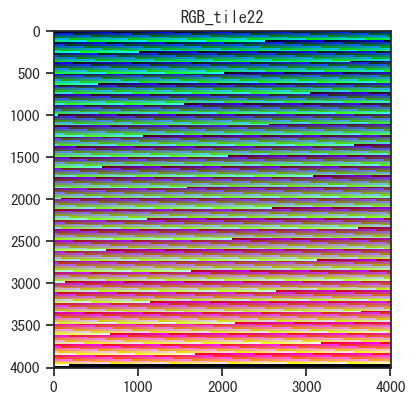

In [5]:
g = GridPlot((1, 4),(20,10))

rgb = np.linspace(0, 255, LUT_3D_SIZE, dtype=np.uint8)
tiles_all = np.stack(np.meshgrid(rgb, rgb, rgb, indexing='ij'), axis=-1) # RGBの組み合わせ
tiles_all = tiles_all.reshape(-1,3) # フラットにする

full_img = np.zeros((imgsize, imgsize, 3), dtype=np.uint8) # IMGSIZE*IMGSIZE の黒画像を作成

for i, tile in enumerate(tiles_all):
    x = i % tileN 
    y = i // tileN #何段目
    full_img[y * TILESIZE:(y + 1) * TILESIZE,
             x * TILESIZE:(x + 1) * TILESIZE] = tile


print(full_img.shape,"LUT_3D_SIZE",LUT_3D_SIZE)
g.AddImg(full_img,2,f"RGB_tile{TILESIZE}")
g.Show()
Save(full_img, f"{INDIR}/RGB_SIZE{LUT_3D_SIZE}_TILE{TILESIZE}px.png")

### プリセット作成

LUT仕様

https://resolve.cafe/developers/luts/#3d-lut
- b,g,rの優先度でソートされた(RGB)の羅列
- RGB各値の範囲は0~1

metaデータの書き方
```
TITLE "preset name"
# Created by: babnomiyako

# meta data
LUT_3D_SIZE 32
DOMAIN_MIN 0.0 0.0 0.0
DOMAIN_MAX 1.0 1.0 1.0

0.133333 0.101961 0.094118
0.156863 0.101961 0.090196
...
```

Adobe Photoshop 2024では、メタデータは`LUT_3D_SIZE xx`さえあれば動作する模様。また、空白行の有無は関係ない。

In [22]:
OUTDIR=f"{BASEDIR}/OUT/SIZE{LUT_3D_SIZE}_TILE{TILESIZE}px"
# OUTDIR=f"{BASEDIR}/OUT/SIZE{LUT_3D_SIZE}_TILE{TILESIZE}px_0928"
INDIR=f"{BASEDIR}/IN"
print(f"{len(FindImageFiles(OUTDIR))} images found.")

276 images found.


In [205]:
LUT_SAVE_DIR = f"{BASEDIR}/LUT/SIZE{LUT_3D_SIZE}_TILE{TILESIZE}px"
IN_full_path = f"{INDIR}/RGB_SIZE{LUT_3D_SIZE}_TILE{TILESIZE}px.png"
IN_full = Read(IN_full_path)
AUTHOR_NAME = "babnomiyako"

print(f"{FilenameWOExt(IN_full_path)}: {IN_full.shape}")
print(f"LUT_3D_SIZE:\t{LUT_3D_SIZE} step\ntileの一辺:\t{TILESIZE} px\n")
imgsize = IN_full.shape[0]  # 1辺のpixel数

# OUT画像における各tile周縁pxはjpg圧縮で劣化する為あてにならない。各tile中心部の色のみを取り出す。
c_idxs = np.arange(TILESIZE // 2, imgsize, TILESIZE)  # 各tileの中心pxの位置(x,y座標)

IN_c = IN_full[np.ix_(c_idxs, c_idxs)]  # IN画像の各tileの中心pxの位置のみ抜き出した画像

# 要求されるLUT解像度LUT_3D_SIZEに対して、必要なpx総数はLUT_3D_SIZE^3 pxである。
# しかし正方形画像のpx総数は、それよりも多い場合がある。余剰分が末尾の何px分かを求める。
print(f"有効tileの総数:\t{LUT_3D_SIZE**3} 中心部のみ画像のサイズ:\t{len(c_idxs)**2} px")
tileN_unused = len(c_idxs)**2 - LUT_3D_SIZE**3
print(f"末尾余剰:\t{tileN_unused}px")

# 余剰を削除
IN = IN_c.reshape((-1, 3)) #tile中心以外を間引いた正方形画像を、長い1次元画像にする。
IN = IN[: -1 * tileN_unused]  # 余剰を削除

# .cubeの仕様通りに B,G,Rの優先度で昇順ソート -> idxを返す
# https://resolve.cafe/developers/luts/#3d-lut
order_idx = np.lexsort((IN[:, 0], IN[:, 1], IN[:, 2]))  # ※np.lexsort の引数の順とソートの処理順は逆

RGB_SIZE32_TILE22px: (4004, 4004, 3)
LUT_3D_SIZE:	32 step
tileの一辺:	22 px

有効tileの総数:	32768 中心部のみ画像のサイズ:	33124 px
末尾余剰:	356px


In [190]:
for outmap in tqdm(FindImageFiles(OUTDIR)):
    # g=GridPlot((1,3))

    preset_name = FilenameWOExt(outmap)

    OUT_full = Read(f"{outmap}")
    # g.AddImg(OUT_full,2,f"OUT_full{OUT_full.shape[:2]}")

    # IN画像に対するOUT画像じゃなさそうだったらエラー
    if IN_full.shape != OUT_full.shape:
        raise ValueError("I/O Image sizes do not match.")

    #tile中心の無劣化pxのみ抜き出す
    OUT_c = OUT_full[np.ix_(c_idxs, c_idxs)] 

    # g.AddImg(OUT_c,3,f"OUTcenter{OUT_c.shape[:2]}")
    OUT = OUT_c.reshape((-1, 3)) #tile中心以外を間引いた正方形画像を、長い1次元画像にする。
    OUT = OUT[:-1 * tileN_unused]  # 余剰を削除

    lut = (OUT[order_idx] / 255) #0~1範囲にスケール

    tqdm.write(preset_name)
    print(lut)
    """ ここをコメントアウトして変換&保存
    if not os.path.exists(LUT_SAVE_DIR):
        os.makedirs(LUT_SAVE_DIR)
    with open(f"{LUT_SAVE_DIR}/{preset_name}.cube", 'w') as f:
        f.write(f"TITLE \"{preset_name}\"\n")
        f.write(f"# Created by: {AUTHOR_NAME}\n")
        f.write(f"\n")
        f.write(f"# meta data\n")
        f.write(f"LUT_3D_SIZE {LUT_3D_SIZE}\n")
        f.write(f"DOMAIN_MIN 0.0 0.0 0.0\n")
        f.write(f"DOMAIN_MAX 1.0 1.0 1.0\n")
        f.write(f"\n")
        for row in lut:
            # line = ' '.join(map(str, row))
            line = ' '.join([f"{value:.6f}" for value in row]) # ファイルサイズ削減の為不要な桁数を減らす
            f.write(line + '\n')
    """
    clear_output()

# lut

 16%|█▌        | 43/276 [00:06<00:35,  6.58it/s]

CC_CN13
[[0.17254902 0.19215686 0.26666667]
 [0.26666667 0.15686275 0.24705882]
 [0.34117647 0.14901961 0.23137255]
 ...
 [0.94901961 0.89803922 0.97647059]
 [0.94901961 0.89803922 0.96862745]
 [0.94901961 0.89803922 0.97647059]]


KeyboardInterrupt: 

## プリセット適用
` pip install pillow pillow-lut`

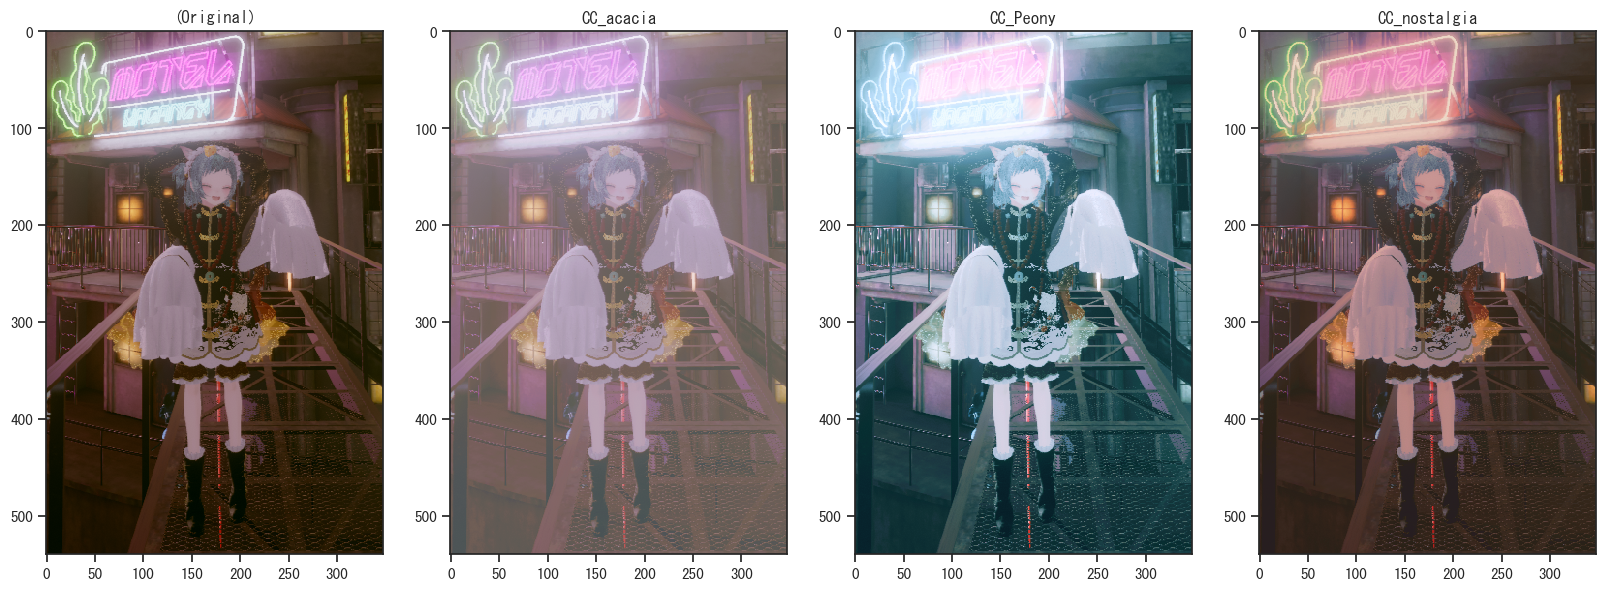

In [121]:
from PIL import Image
from pillow_lut import load_cube_file

lutpaths=[rf"{BASEDIR}/LUT/SIZE32_TILE22px/CC_acacia.cube",
          rf"{BASEDIR}/LUT/SIZE32_TILE22px/CC_Peony.cube",
          rf"{BASEDIR}/LUT/SIZE32_TILE22px/CC_nostalgia.cube"]

img = Image.open(rf'{BASEDIR}/Sample/kobako.png').convert('RGB')

g = GridPlot((1, 4),(20,10))
g.AddImg(np.array(img), 1,"(Original)")

i=2
for lutpath in lutpaths:
    lut = load_cube_file(lutpath)
    filtered_img=img.filter(lut)
    g.AddImg(np.array(filtered_img), i,FilenameWOExt(lutpath))
    i+=1
g.Show()

## いろいろな分析

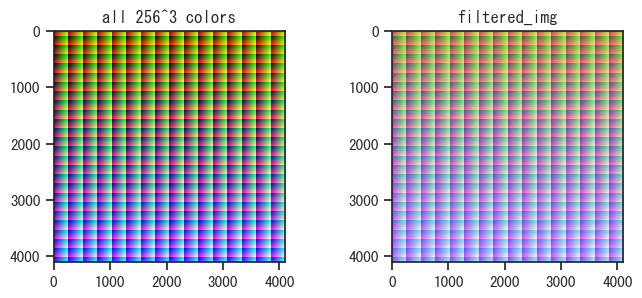

In [146]:
def AllColorsVector():
    rgb = np.linspace(0, 255, 256, dtype=np.uint8)
    allcolors = np.array(np.meshgrid(rgb, rgb, rgb)).T.reshape(-1, 3)
    return allcolors

# ある色(r,g,b)を変換した後の色を(r',g',b')とした際に、
# A[r,g,b]=(r',g',b')となる様な(256,256,256,3)形状の配列Aを返す関数
def GetFullLUT(lut_path,show=False):
    input_colors_img = AllColorsVector().reshape(4096, 4096, 3)

    lut_filter = load_cube_file(lut_path)
    filtered_img = np.array(Image.fromarray(input_colors_img).filter(lut_filter))

    in_c = input_colors_img.reshape(-1, 3)
    out_c = filtered_img  .reshape(-1, 3)
    lut = np.full((256, 256, 256, 3), np.nan)
    lut[in_c[:, 0], in_c[:, 1], in_c[:, 2]] = out_c
    
    if show:
        grid = GridPlot(gridsize=(1, 2), figsize=(8, 3))
        grid.AddImg(input_colors_img, 1, "all 256^3 colors")
        grid.AddImg(filtered_img, 2, "filtered_img")
        grid.Show()

    return lut

lut = GetFullLUT(
    rf"{BASEDIR}/LUT/SIZE32_TILE22px/CC_acacia.cube",
    show=True
)

色相Hは、RGBの最大値と最小値が同じ場合は0とする。そうでない場合は、

最大値がRのとき: (G - B) / (最大値 - 最小値) * 60
最大値がGのとき: (B - R) / (最大値 - 最小値) * 60 + 120
最大値がBのとき: (R - G) / (最大値 - 最小値) * 60 + 240
彩度Sは、RGBの最大値と最小値が同じ場合は0とする。そうでない場合は、

明度Vが0.5以下のとき: (最大値 - 最小値) / (最大値 + 最小値)
明度Vが0.5より大きいとき: (最大値 - 最小値) / (2 - 最大値 - 最小値)
明度Vは、RGBの最大値をそのまま用いる。

輝度Lは、RGBの平均をそのまま用いる。←嘘過ぎ嘘過ぎ嘘過ぎ

何を調べる?
- 一番飛距離がデカいところにどんな特徴が?←とりあえず赤色強調しとけ的な風潮あるんで
- 全体的に色が薄くなりすぎなやつを仕分けたい→輝度・明度の平均値、分布を調べてみる?
- コントラストが弱まっているか強まっているか:コントラストの指標って何?RGBのレンジが小さいとコントラストが弱い。M字形分布になっていればコントラストが強い

In [227]:
m = GetFullLUT(
    rf"{BASEDIR}/LUT/SIZE32_TILE22px/CC_nostalgia.cube"
    )

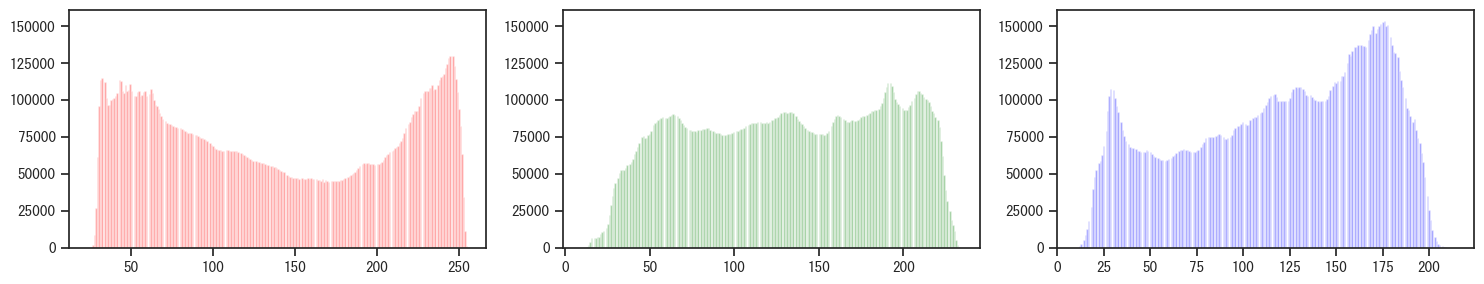

In [228]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))  # 1行3列のサブプロット

# 各チャネルのヒストグラムを描画
axs[0].hist(m[:, :, :, 0].flatten(), alpha=0.4, bins=256, color='red')
axs[1].hist(m[:, :, :, 1].flatten(), alpha=0.4, bins=256, color='green')
axs[2].hist(m[:, :, :, 2].flatten(), alpha=0.4, bins=256, color='blue')

# Y軸の範囲を揃える
max_ylim = max(ax.get_ylim()[1] for ax in axs)  # 最大のY値を取得
for ax in axs:
    ax.set_ylim(0, max_ylim)  # Y軸の範囲を設定

plt.tight_layout()  # レイアウトの調整
plt.show()

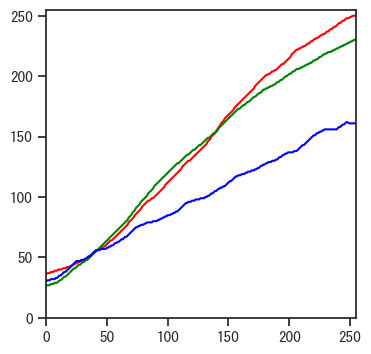

In [263]:
# あるG,B固定断面におけるRの変動
plt.figure(figsize=(4, 4))
plt.ylim(0, 255); plt.xlim(0, 255)
i=10
plt.plot(np.arange(0, 256, 1), m[:, i, i, 0], color='red')
plt.plot(np.arange(0, 256, 1), m[i, :, i, 1], color='green')
plt.plot(np.arange(0, 256, 1), m[i, i, :, 2], color='blue')

(array([  9112.,  48808., 162056., 246601., 379016., 399163., 289498.,
        259062., 259894., 276893., 256706., 234979., 298987., 264978.,
        263988., 253635., 269838., 301587., 318226., 292112., 299900.,
        314366., 314471., 330007., 361724., 510244., 399595., 395396.,
        408612., 439991., 429837., 404125., 393604., 418305., 463881.,
        444540., 526302., 675434., 575230., 606307., 600238., 559507.,
        509727., 416420., 373149., 296213., 172659.,  44780.,   6771.,
           742.]),
 array([  9.  ,  13.08,  17.16,  21.24,  25.32,  29.4 ,  33.48,  37.56,
         41.64,  45.72,  49.8 ,  53.88,  57.96,  62.04,  66.12,  70.2 ,
         74.28,  78.36,  82.44,  86.52,  90.6 ,  94.68,  98.76, 102.84,
        106.92, 111.  , 115.08, 119.16, 123.24, 127.32, 131.4 , 135.48,
        139.56, 143.64, 147.72, 151.8 , 155.88, 159.96, 164.04, 168.12,
        172.2 , 176.28, 180.36, 184.44, 188.52, 192.6 , 196.68, 200.76,
        204.84, 208.92, 213.  ]),
 <BarContainer obj

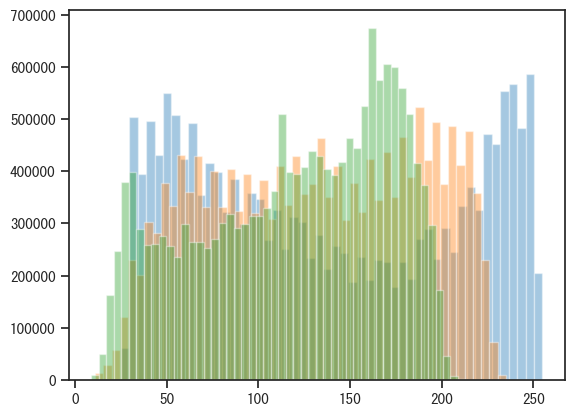

In [245]:
# for PRESETNAME in ["CU11","nostalgia","YM01"]:
PRESETNAME="nostalgia"
M = np.load(f'filters/{PRESETNAME}.npy')
plt.hist(M[:,:,:,0].flatten(),alpha=0.4,bins=50)
plt.hist(M[:,:,:,1].flatten(),alpha=0.4,bins=50)
plt.hist(M[:,:,:,2].flatten(),alpha=0.4,bins=50)


### 調節

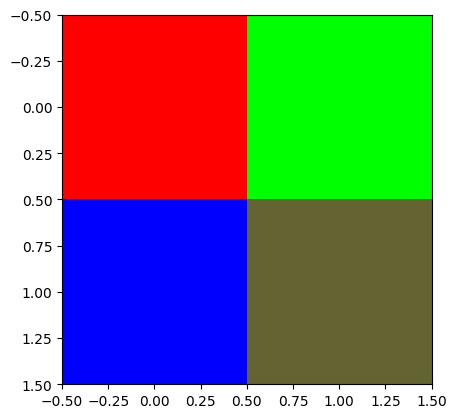

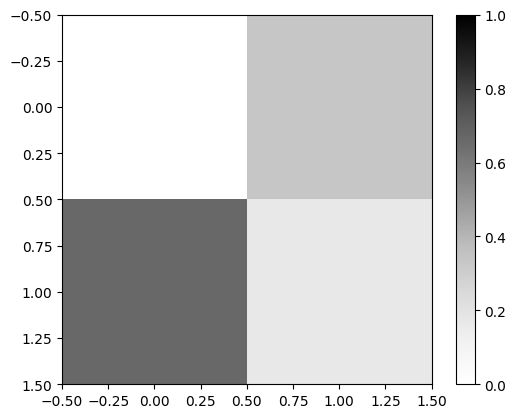

In [112]:
# test colorsys
imgdat = np.array(
    [[[255, 0, 0], [0, 255, 0]],
     [[0, 0, 255], [100, 100, 50]]],dtype="uint8"
)
plt.imshow(Image.fromarray(imgdat))
plt.show()

a=np.array([[ colorsys.rgb_to_hsv(r / 255, g / 255, b / 255)for r, g, b in i]for i in imgdat])

fig, ax = plt.subplots()
im = ax.imshow(a[:,:,0], cmap='Greys',vmin=0,vmax=1)
plt.colorbar(im, ax=ax)# 凡例バーを表示
plt.show()


In [72]:
def my_func(a):
    """Average first and last element of a 1-D array"""
    return a.sum()
b = np.array([[1,2,3], [4,5,6], [7,8,9]])
np.apply_along_axis(my_func, 0, b)


array([12, 15, 18])

In [29]:
import colorsys
in_[0,1]


a=[colorsys.rgb_to_hsv(r/255, g/255, b/255) for r,g,b in in_]

ValueError: too many values to unpack (expected 3)